In [1]:
import plotly.express as px
import plotly.graph_objects as go
from IPython.display import IFrame, Image
from entur_collector.dataanalysis.deviationssampler import refine_deviations

In [2]:
# Convenience function to allow changing between interactive and static images
# Needed to show figures on GitHub notebook preview
plotly_interactive = False
def show_figure(fig: go.Figure):
    global fig_count
    if plotly_interactive:
        return fig
    else:
        return Image(data=fig.to_image(format='png', scale=2))

In [3]:
df = refine_deviations()

In [4]:
df.head()

,aimed_arrival,timestamp,expected_arrival,expected_delay,day_of_week,time_of_day,day_since_start,month
30,2024-12-02 06:34:00+01:00,2024-12-02 05:34:28+01:00,2024-12-02 06:36:38+01:00,0 days 00:02:38,0,06:34:00,0,12
36,2024-12-02 07:04:00+01:00,2024-12-02 06:11:12+01:00,2024-12-02 07:12:41+01:00,0 days 00:08:41,0,07:04:00,0,12
42,2024-12-02 07:34:00+01:00,2024-12-02 06:48:40+01:00,2024-12-02 07:51:06+01:00,0 days 00:17:06,0,07:34:00,0,12
48,2024-12-02 08:04:00+01:00,2024-12-02 07:33:11+01:00,2024-12-02 08:33:23+01:00,0 days 00:29:23,0,08:04:00,0,12
54,2024-12-02 08:34:00+01:00,2024-12-02 07:56:32+01:00,2024-12-02 08:58:01+01:00,0 days 00:24:01,0,08:34:00,0,12


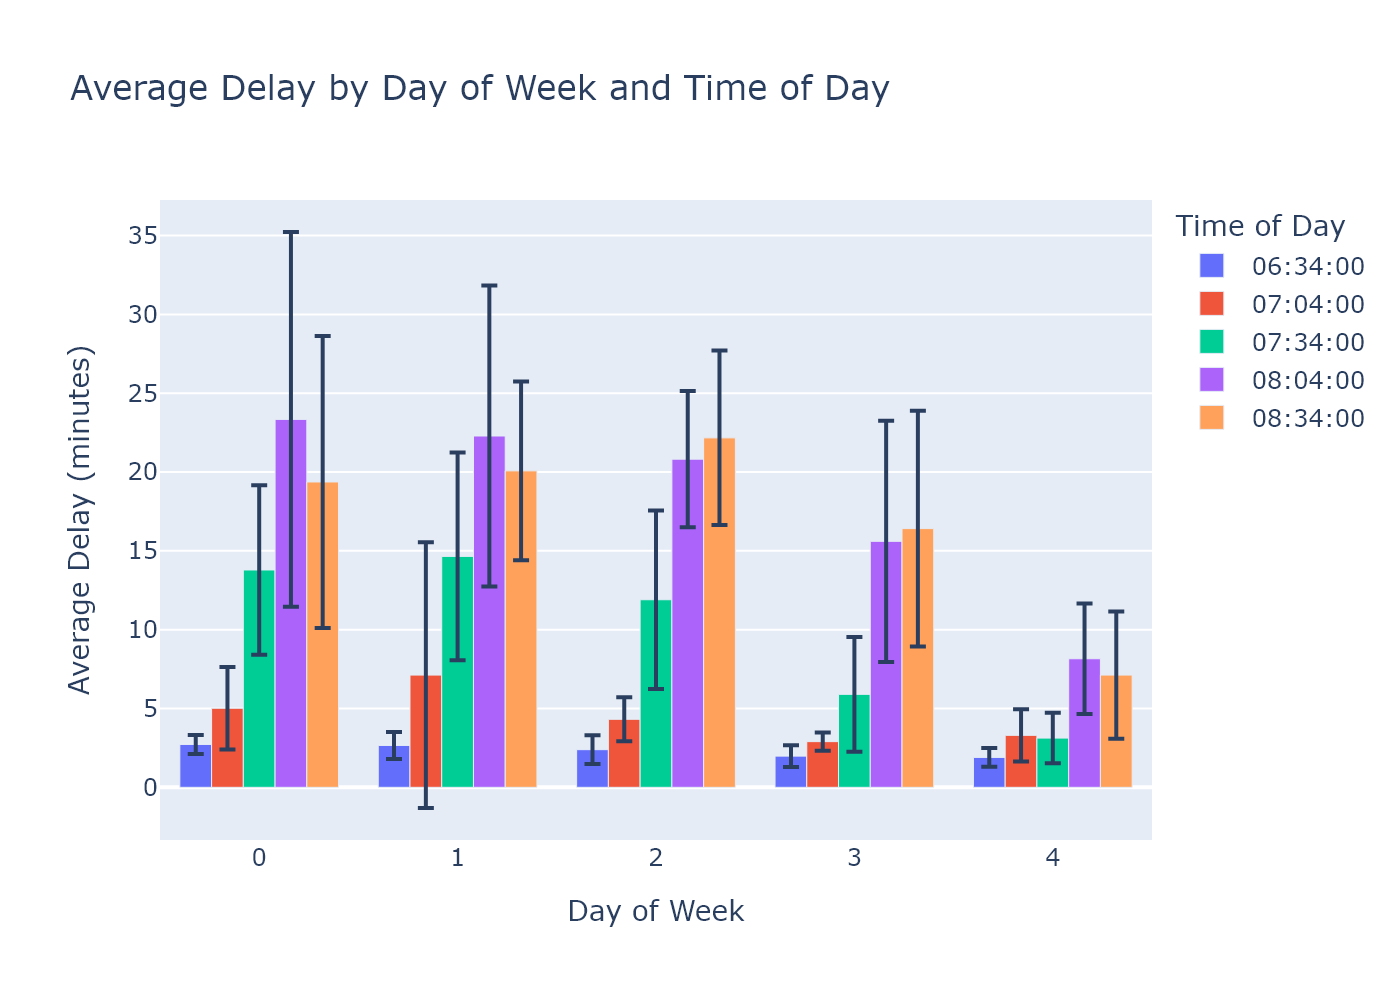

In [5]:
df.groupby(["day_of_week", "time_of_day"])

mean_delays = df.groupby(["day_of_week", "time_of_day"])["expected_delay"].mean().dt.total_seconds() / 60
std_delays = df.groupby(["day_of_week", "time_of_day"])["expected_delay"].std().dt.total_seconds() / 60
mean_delays = mean_delays.reset_index()
fig = px.bar(mean_delays, x="day_of_week", y="expected_delay", color="time_of_day",
             labels={'day_of_week': 'Day of Week', 'expected_delay': 'Average Delay (minutes)', 'time_of_day': 'Time of Day'},
             title='Average Delay by Day of Week and Time of Day',
             error_y=std_delays,
             barmode='group')
show_figure(fig)